In [1]:
# Imports 
import os
import torch

In [2]:
from src.models import *
from src.dhand import *
from src.utils import *

In [3]:
device = torch.device('cpu')

In [4]:
# Create datasets
df = read_source(
    '/home/fdi/AliBagheriNejad/Thesis/MECO/data/vib_case_dataset_ICMS Dataset.xlsx', 
    show_columns=False
)

df1,df2  = double_data(
    df,
    ['VibGt_39VS4_1', 'VibGt_39VS4_2'],
    sample_length = 1024 
)

files = save_to_temp_df(
    df1,
    df2,
    dir = '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp'    
)

2025-01-20 15:13:25,381 - INFO - Directory '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp' is ready for saving files.
2025-01-20 15:13:25,437 - INFO - Saved DataFrame to '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_0.csv'
2025-01-20 15:13:25,469 - INFO - Saved DataFrame to '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_1.csv'


In [4]:
# Read datafiles (If needed)
df1 = pd.read_csv('/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_0.csv')
df2 = pd.read_csv('/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_1.csv')

In [5]:
print(f'Shape of dataset 1 is {df1.shape}')
print(f'Shape of dataset 2 is {df2.shape}')


Shape of dataset 1 is (27, 1024)
Shape of dataset 2 is (27, 1024)


In [5]:
from sklearn.preprocessing import StandardScaler
import joblib

In [6]:
X_scaled = np.zeros(shape=(df1.shape[0], df2.shape[1], 2))
X_scaled_self = np.zeros(shape=(df1.shape[0], df2.shape[1], 2))
df_list = [df1,df2]

s_dir = '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights/scaler'


for i in range(X_scaled.shape[2]):

    scaler = joblib.load(
        os.path.join(
            s_dir,
            f'scaler_p_mfda_01_{i}.pkl'
        )
    )

    X_scaled[:,:,i] = scaler.transform(df_list[i].values)
    X_scaled_self[:,:,i] = scaler.fit_transform(df_list[i].values)

/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
X_tensor = torch.tensor (X_scaled, dtype = torch.float32).to(device)
X_tensor_self = torch.tensor (X_scaled_self, dtype = torch.float32).to(device)

In [8]:
model = Network(10,2).to(device)

In [9]:
# Load weights 
loaded_sd = torch.load(
        os.path.join(
            '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
            'mafda_test_1.pth'
        ), map_location=device
    )

del loaded_sd["conv.conv.weight"]
del loaded_sd["conv.conv.bias"]
# Weight path
model.load_state_dict(loaded_sd)

/tmp/ipykernel_18121/2416463155.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_sd = torch.load(


<All keys matched successfully>

In [32]:
features = extract_second_features(model, X_tensor_self, device)
features[features.isnan()] = 0

In [27]:
import umap

In [33]:
umap_reducer = umap.UMAP(n_components=2, random_state=69)
embeddings = umap_reducer.fit_transform(features)

/home/fdi/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [21]:
labels = np.linspace(0,1,embeddings.shape[0])

In [20]:
from matplotlib.colors import ListedColormap
cmap = plt.get_cmap('gist_ncar')

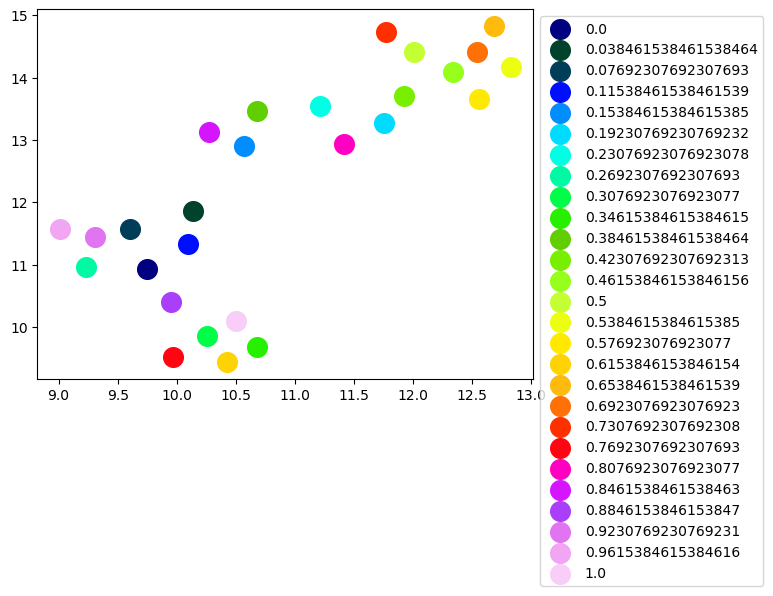

In [34]:

for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

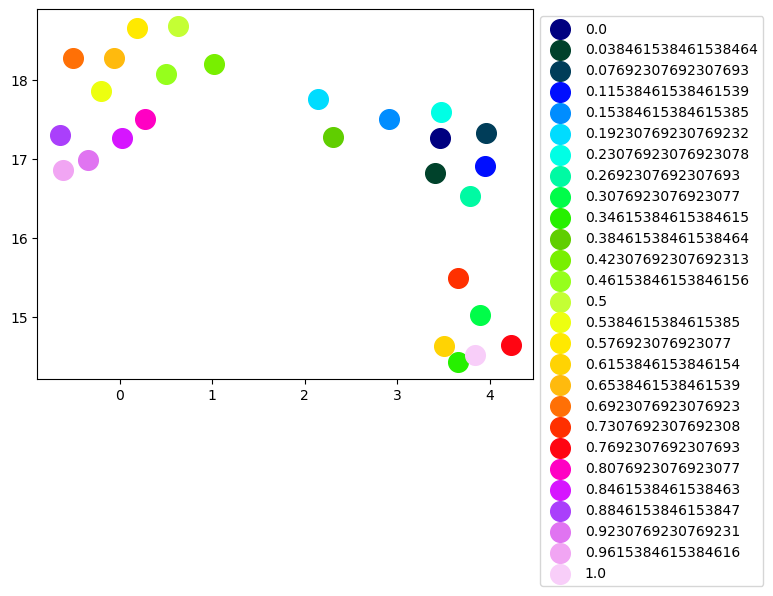

In [31]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

In [ ]:
# Delete datasets
# data_files = ['/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_0.csv',
#  '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_1.csv']
# clear_files(data_files)